# To fitting BCS thoery $T_c$ with our numerical result

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from tqdm import tqdm
from scipy.constants import k as k_B, e
from math import isclose
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit


## parameters

In [3]:
# Tight-binding model parameters
a = 3.18
t1 = 146e-3
t2 = -0.40 * t1
t3 = 0.25 * t1
mu = 0

# Physical constants in convenient units
mu_B_eVT = 5.7883818012e-5  # Bohr magneton in eV/T
k_B_eV = k_B / e           # Boltzmann constant in eV/K

# Zeeman-type spin-splitting parameters (initial values)
alpha = 0
beta = 0

# Define the critical temperature and convert it to units of eV
Tc_K = 6.5
Tc_eV = k_B_eV * Tc_K

# const
hbar_eVs = 6.582119569e-16
kb_ev_val = 8.617333262e-5

## Core functions

In [4]:
# energy dispersion, corresponding to H_{kin} term
def eps_Mo(kx, ky, mu):
    return (2*t1*(np.cos(ky*a) + 2*np.cos(np.sqrt(3)/2*kx*a)*np.cos(0.5*ky*a))
            +2*t2*(np.cos(np.sqrt(3)*kx*a) + 2*np.cos(np.sqrt(3)/2*kx*a)*np.cos(1.5*ky*a))
            +2*t3*(np.cos(2*ky*a) + 2*np.cos(np.sqrt(3)*kx*a)*np.cos(ky*a))-mu)

# g_z(k) for Zeeman-type SOI
def core_g(kx, ky):
    # sin(ky a) - 2 cos(√3/2 kx a) sin(ky a/2)
    return np.sin(ky*a) - 2*np.cos(np.sqrt(3)/2*kx*a)*np.sin(0.5*ky*a)

def f_k(kx, ky):
    # f(k) = | core_g(k) |
    return np.abs(core_g(kx, ky))

def F_k(kx, ky, fK, beta):
    # F(k) = beta * tanh[ f(K) - f(k) ] - 1
    return beta * np.tanh(fK - f_k(kx, ky)) - 1.0

def gzz(kx, ky, fK, beta):
    return F_k(kx, ky, fK, beta) * core_g(kx, ky)

# g_R(k) for Rashba-type SOI
def gR_core(kx, ky):
    gx_core = -np.sin(ky*a) - np.cos(np.sqrt(3)/2*kx*a)*np.sin(0.5*ky*a)
    gy_core = np.sqrt(3) * np.sin(np.sqrt(3)/2*kx*a)*np.cos(0.5*ky*a)
    return gx_core, gy_core

def gR_vec(kx, ky, fK, beta):
    Fk = F_k(kx, ky, fK, beta)
    gx_core, gy_core = gR_core(kx, ky)
    return Fk * gx_core, Fk * gy_core

def gR_mag(kx, ky, fK, beta):
    gx, gy = gR_vec(kx, ky, fK, beta)
    return np.sqrt(gx*gx + gy*gy)

# High symmetry points
Gamma = np.array([0.0, 0.0])
K = np.array([0.0, 4*np.pi/(3*a)])
M = np.array([np.pi/(np.sqrt(3)*a), np.pi/a])

# Path, Γ←K (neg s) and K→M (pos s), near K
def path_around_K(smax=0.2, N=501):
    v_GK = K - Gamma
    v_KM = M - K
    L_GK = np.linalg.norm(v_GK)
    L_KM = np.linalg.norm(v_KM)

    u1 = np.linspace(1 - smax/L_GK, 1.0, N)   # Γ→K near K
    u2 = np.linspace(0.0, smax/L_KM, N)       # K→M near K

    k_GK = Gamma + u1[:,None]*v_GK
    k_KM = K     + u2[:,None]*v_KM

    s_GK = -(1.0 - u1) * L_GK    # [-smax, 0]
    s_KM =  (u2      ) * L_KM    # [ 0, +smax]

    kx = np.concatenate([k_GK[:,0], k_KM[:,0]])
    ky = np.concatenate([k_GK[:,1], k_KM[:,1]])
    s  = np.concatenate([s_GK,       s_KM])

    return kx, ky, s

kx, ky, s = path_around_K(smax=0.2, N=501)

# Align to E_F
mu_guess = 0.0
E_K_raw  = eps_Mo(0, 4*np.pi/(3*a), mu_guess)     # Energy at K point with initial mu_guess
E_F      = E_K_raw + 0.15
E = lambda kx,ky: eps_Mo(kx,ky,mu_guess)-E_F


kx_l, ky_l, s_l = path_around_K(0.2, 301)
mask_R = s_l >= 0
kF_idx = np.argmin(np.abs(E(kx_l[mask_R], ky_l[mask_R])))
kF_kx, kF_ky = kx_l[mask_R][kF_idx], ky_l[mask_R][kF_idx]

# alpha and beta calibration
fK    = f_k(K[0], K[1])
coreK = abs(core_g(K[0], K[1]))
alpha = (3e-3) / (2.0*max(coreK,1e-18))

def beta_from_target(target_meV):
    betas = np.linspace(0.5, 200.0, 2001)
    spls  = np.array([2*alpha*abs(gzz(kF_kx, kF_ky, fK, b)) for b in betas])
    return float(betas[np.argmin(np.abs(spls - target_meV*1e-3))])

# ------------------------ Fermi shell ------------------------
# K and -K patches in k-space
def k_patch(center, rad, Nk):
    qx = np.linspace(-rad, rad, Nk)
    qy = np.linspace(-rad, rad, Nk)
    Qx, Qy = np.meshgrid(qx, qy, indexing='xy')
    mask = (Qx**2 + Qy**2 <= rad**2)
    kx = center[0] + Qx[mask]
    ky = center[1] + Qy[mask]
    return kx, ky

# Build Fermi surface shell samples around K and -K
def build_FS_shell(mu_guess, EF, rad, Nk, n_keep):
    kxK,  kyK  = k_patch(K,   rad, Nk)
    kxKm, kyKm = k_patch(-K,  rad, Nk)
    xiK  = eps_Mo(kxK,  kyK,  mu_guess) - EF
    xiKm = eps_Mo(kxKm, kyKm, mu_guess) - EF
    idxK  = np.argsort(np.abs(xiK))[:n_keep]
    idxKm = np.argsort(np.abs(xiKm))[:n_keep]
    return (kxK[idxK], kyK[idxK]), (kxKm[idxKm], kyKm[idxKm])

# ------------------------ Susceptibility calculation ------------------------
# 2x2 identity and Pauli matrices
I2 = np.eye(2, dtype=complex)
sx = np.array([[0, 1],[1, 0]], dtype=complex)
sz = np.array([[1, 0],[0,-1]], dtype=complex)

# k grid setup
Nk = 121
kx_vals = np.linspace(-np.pi/a, np.pi/a, Nk)
ky_vals = np.linspace(-np.pi/a, np.pi/a, Nk)
# Precompute k-grid and dispersion once
kx_grid, ky_grid = np.meshgrid(kx_vals, ky_vals, indexing='xy')
eps_grid_global = eps_Mo(kx_grid, ky_grid, mu)

# Encapsulated as g_z(kx, ky) without additional parameters
gz_func = lambda kx, ky: gzz(kx, ky, fK, beta)

# calculate χ using the formula with vectorization over k-grid
def chi_singlet_vectorized(T, H, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw):

    # K-point k-grid
    kxK,  kyK  = kK

    # Energy at k
    EK   = eps_Mo(kxK,  kyK,  mu_guess) - EF

    # Zeeman-type component DeltaZ at k
    DeltaZ_K  = alpha_Z * gz_func(kxK,  kyK)

    # Rashba components g_Rx, g_Ry at k
    gRxK, gRyK   = gR_func(kxK,  kyK)

    # Matsubara frequencies
    wn = (2*np.arange(Nw)+1) * np.pi * k_B_eV * T

    # use [:, None] and [None, :] to vectorize over k and omega_n. (broadcasting)
    A1   = 1j*wn[:,None] - EK[None,:]    # G(k, i omega_n)

    # Using symmetry properties: eps(-k) = eps(k)
    A2  = -1j*wn[:,None] - EK[None,:]   # G(-k, -i omega_n)

    # 3 components of effective field B at K
    Bx  = (-mu_B_eVT * H) + alpha_R * gRxK[None,:]      # B_x = -mu_B*H + alpha_R * g_Rx(k)
    By  = (alpha_R * gRyK)[None,:]                      # B_y = alpha_R * g_Ry(k)
    Bz  = (-DeltaZ_K)[None,:]                           # B_z = -Delta_Z(k)

    # 3 components of effective field B at -k (using symmetry properties)
    # Bx2: gRx(-k) = -gRx(k) (odd function)
    Bx2 = (-mu_B_eVT * H) - alpha_R * gRxK[None,:]
    # By2: gRy(-k) = gRy(k) (even function)
    By2 = (alpha_R * gRyK)[None,:]
    # Bz2: DeltaZ(-k) = -DeltaZ(k) (odd function)
    Bz2 = -(-DeltaZ_K)[None,:]

    # 2×2 green's function elements G(k, i omega_n)
    denominator1  = (A1*A1  - Bx*Bx  - By*By  - Bz*Bz)
    Guu    = (A1 - Bz)/denominator1
    Gdd    = (A1 + Bz)/denominator1
    Gud    = (Bx - 1j*By)/denominator1
    Gdu    = (Bx + 1j*By)/denominator1

    # 2×2 green's function elements G(-k, -i omega_n)
    denominator2 = (A2*A2 - Bx2*Bx2 - By2*By2 - Bz2*Bz2)
    Guu_m  = (A2 - Bz2)/denominator2
    Gdd_m  = (A2 + Bz2)/denominator2
    Gud_m  = (Bx2 - 1j*By2)/denominator2
    Gdu_m  = (Bx2 + 1j*By2)/denominator2

    # singlet pairing susceptibility
    term = Guu*Gdd_m - Gdu*Gud_m
    chi  = (k_B_eV*T) * np.real(term.sum()) / kxK.size
    return float(chi)

# find V from Tc at H=0
def determine_V(Tc, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw):
    chi_Tc0 = chi_singlet_vectorized(Tc, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
    return 1.0 / chi_Tc0




## DOS code

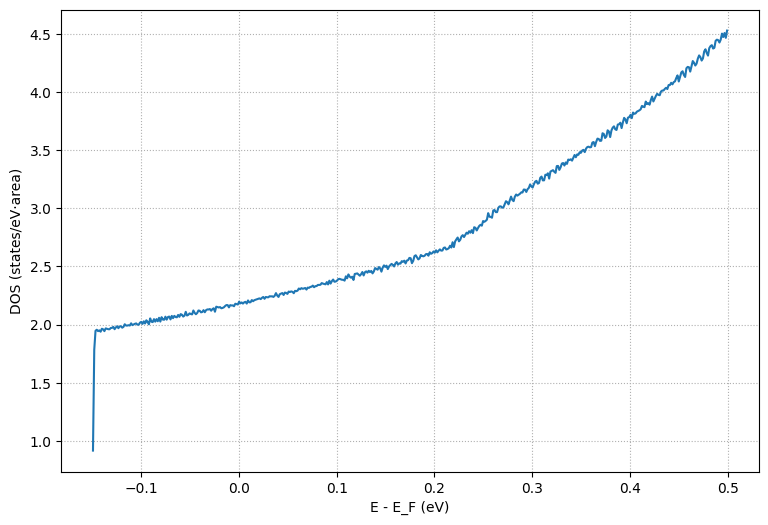

In [26]:

alpha_Z = (3e-3) / (2.0 * max(coreK, 1e-18))
eta = 0.02
alpha_R = eta * alpha_Z

# EF scan setup
mu_guess = 0.0
EF_center = E_F
EF_scan_range = 1      # eV
N_mu_points = 100
EF_range = np.linspace(EF_center - EF_scan_range, EF_center + EF_scan_range, N_mu_points)
dE_range = EF_range - EF_center 

def compute_DOS_relative_SOC(mu_guess, EF,
                             alpha_Z, alpha_R, fK, beta,
                             Nk=501, n_bins=400,
                             E_rel_range=(-0.15, 0.50)):

    # 1. k 网格（保持和你原来一样）
    kx_vals = np.linspace(-2*np.pi/a, 2*np.pi/a, Nk)
    ky_vals = np.linspace(-2*np.pi/a, 2*np.pi/a, Nk)
    kx_grid, ky_grid = np.meshgrid(kx_vals, ky_vals, indexing="xy")

    # 2. 裸能带相对费米能 (不含 SOC)
    eps0 = eps_Mo(kx_grid, ky_grid, mu_guess) - EF   # E_kin(k) = ε(k) - E_F

    # 3. SOC 项：Ising + Rashba
    gz_vals = gzz(kx_grid, ky_grid, fK, beta)        # g_z(k)
    gR_vals = gR_mag(kx_grid, ky_grid, fK, beta)     # |g_R(k)|

    Gabs = np.sqrt((alpha_Z * gz_vals)**2 + (alpha_R * gR_vals)**2)

    # 4. 两支 SOC 分裂能带
    E_plus  = eps0 + Gabs
    E_minus = eps0 - Gabs

    # 5. 合并两支能带做直方图 → 总 DOS
    xi_vals_all = np.concatenate([E_plus.flatten(), E_minus.flatten()])

    # 6. 直方图范围
    E_min, E_max = E_rel_range

    hist, edges = np.histogram(
        xi_vals_all,
        bins=n_bins,
        range=(E_min, E_max),
        density=False
    )

    dE = edges[1] - edges[0]
    BZ_area = (2*np.pi/a) * (2*np.pi/a)

    # 和你原来一样的归一化：states / (eV · area)
    DOS = hist / dE / (Nk*Nk / BZ_area)

    # 能量 bin 中心
    E_rel_centers = 0.5 * (edges[:-1] + edges[1:])

    return E_rel_centers, DOS

E_rel_soc, DOS_soc = compute_DOS_relative_SOC(
                                                mu_guess, E_F,
                                                alpha_Z, alpha_R, fK, beta,
                                                Nk=5000,
                                                n_bins=500,
                                                E_rel_range=(-0.15, 0.50)
                                            )


plt.figure(figsize=(9, 6))
plt.plot(E_rel_soc, DOS_soc)
plt.xlabel("E - E_F (eV)")
plt.ylabel("DOS (states/eV⋅area)")
plt.grid(True, linestyle=':')
plt.show()


## $T_c$ numerical module

Calibrating fixed V...
FS sample per valley (for V calibration): 5000
Building FS shell at calibration point EF_center = -0.7479 eV
FS sample per valley (for V calibration): 5000
Starting Tc(E - E_F) calculation for eta list: [0.02]

--- Processing eta = 0.02 ---
  Calibrated V = 0.044707 for eta = 0.02


  Scanning E (eta=0.02):  98%|█████████▊| 50/51 [02:41<00:03,  3.61s/it]

  Scanning E (eta=0.02): 100%|██████████| 51/51 [02:41<00:00,  3.17s/it]

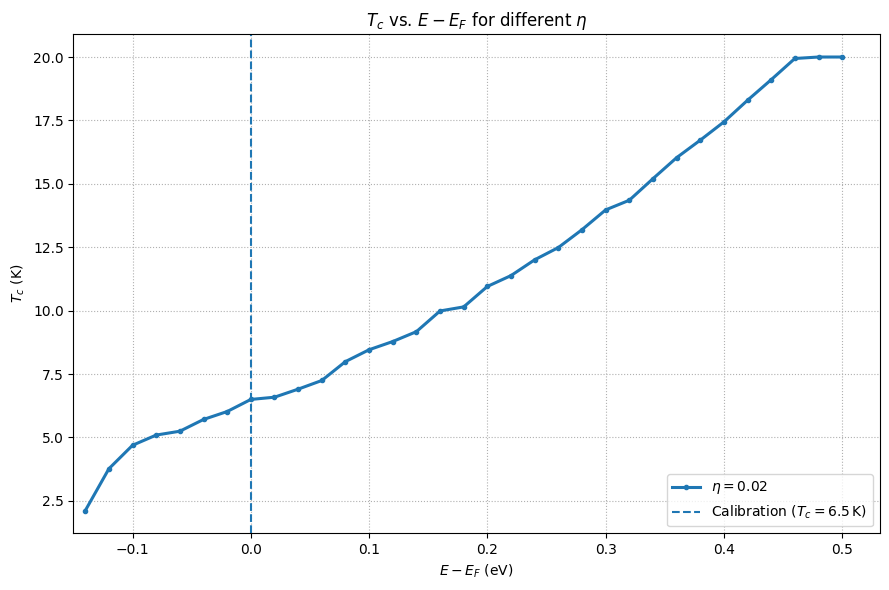

In [ ]:
# ------------------------ Find Tc ----------------------------
# Find Tc at given H=0 using bisection method searching in [Tmin, Tmax]
def find_Tc(V, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw, Tmax=100.0, Tmin=0.01):
    # Check if it's superconducting at all (at T_min) — H=0.0
    chi_minT = chi_singlet_vectorized(Tmin, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
    if V * chi_minT < 1.0:
        return 0.0  # Not superconducting

    # Check if it's normal at Tmax — H=0.0
    chi_maxT = chi_singlet_vectorized(Tmax, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
    if V * chi_maxT > 1.0:
        print(f"Warning: Still superconducting at Tmax={Tmax}K for EF={EF}. Increase Tmax.")
        return Tmax

    lo, hi = Tmin, Tmax
    for _ in range(24):  # Bisection search
        mid = 0.5 * (lo + hi)
        v = V * chi_singlet_vectorized(mid, 0.0, alpha_Z, alpha_R, gz_func, gR_func, kK, mu_guess, EF, Nw)
        if v >= 1.0:  # superconducting (T < Tc)
            lo = mid
        else:         # normal (T > Tc)
            hi = mid
    return 0.5 * (lo + hi)

# ------------------------ Calculate Tc(mu) for fixed V ------------------------
print("Calibrating fixed V...")
target_meV_for_V = 13.0
beta_for_V = beta_from_target(target_meV_for_V)

gz_fun_fixed = lambda kx, ky, fK=fK, b=beta_for_V: gzz(kx, ky, fK, b)
gR_fun_fixed = lambda kx, ky, fK=fK, b=beta_for_V: gR_vec(kx, ky, fK, b)

Tc_initial = 6.5       # K
Nw = 1600              # Matsubara frequencies
n_keep_value = 5000    # FS sample size per valley
FSrad = 0.5            # FS patch radius
Nk_value = 251

# Zeeman-type coupling fixed
alpha_Z_fixed = alpha

# FS shell at original E_F for V calibration
kK_initial, kKm_initial = build_FS_shell(mu_guess, E_F, FSrad, Nk_value, n_keep_value)
print(f"FS sample per valley (for V calibration): {kK_initial[0].size}")

# EF scan setup
EF_center = E_F
EF_scan_range = 0.5      # eV
N_mu_points = 51
EF_range = np.linspace(EF_center - EF_scan_range, EF_center + EF_scan_range, N_mu_points)
dE_range = EF_range - EF_center  # 横坐标: E - E_F

# 仅从该位置开始绘图
x_min = -0.15
mask_global = dE_range >= x_min

# eta values
eta_list = [0.02]

print(f"Building FS shell at calibration point EF_center = {EF_center:.4f} eV")
kK_calib, kKm_calib = build_FS_shell(mu_guess, E_F, FSrad, Nk_value, n_keep_value)
print(f"FS sample per valley (for V calibration): {kK_calib[0].size}")

# Plot
plt.figure(figsize=(9, 6))
print(f"Starting Tc(E - E_F) calculation for eta list: {eta_list}")

for eta in eta_list:
    print(f"\n--- Processing eta = {eta:.2f} ---")

    # Rashba coupling for this eta
    alpha_R_current = eta * alpha_Z_fixed

    # Calibrate V at EF_center to satisfy Tc(EF_center) = Tc_initial for this eta
    V_calibrated = determine_V(Tc_initial, alpha_Z_fixed, alpha_R_current,
                               gz_fun_fixed, gR_fun_fixed,
                               kK_calib, mu_guess, EF_center, Nw)
    print(f"  Calibrated V = {V_calibrated:.6f} for eta = {eta:.2f}")

    Tc_results_for_this_eta = []

    # Scan EF_range; 计算用全范围，绘图再截取
    desc = f"  Scanning E (eta={eta:.2f})"
    for EF_val in tqdm(EF_range, desc=desc):
        # Rebuild FS shell for current EF_val
        kK_new, kKm_new = build_FS_shell(mu_guess, EF_val, FSrad, Nk_value, n_keep_value)

        # Find Tc using calibrated V
        Tc_new = find_Tc(V_calibrated, alpha_Z_fixed, alpha_R_current,
                         gz_fun_fixed, gR_fun_fixed,
                         kK_new, mu_guess, EF_val, Nw, Tmax=100.0)
        Tc_results_for_this_eta.append(Tc_new)

    # 截取从 x_min 开始的部分
    dE_plot = dE_range[mask_global]
    Tc_plot = np.array(Tc_results_for_this_eta)[mask_global]

    # 绘图
    plt.plot(dE_plot, Tc_plot, lw=2.2,
             marker='o', markersize=3,
             label=rf'$\eta={eta:.2f}$')

# Finalize
plt.xlabel(r'$E - E_F$ (eV)')
plt.ylabel(r'$T_c$ (K)')
plt.title(r'$T_c$ vs. $E - E_F$ for different $\eta$')
plt.axvline(0.0, ls='--', label=f'Calibration ($T_c={Tc_initial}\\,$K)')
plt.xlim(left=x_min)
plt.grid(True, ls=':')
plt.legend()
plt.tight_layout()
plt.show()


## Fitting


By '$k_B T_c \approx 1.13 \hbar \omega_D e^{-\frac{1}{N(0)V}}$', we can have the $T_c(\mu)$ based on BCS theory

正在用 SOC DOS 构建插值 N(E - E_F)...

准备进行局部拟合...
拟合范围: [-0.15, -0.05] eV
有效拟合点数: 5
------------------------------
局部 Best Fit 拟合成功!
V_eff       = 0.2628 eV
hbar * w_D  = 500.00 meV
R^2 (local) = 0.5793
------------------------------


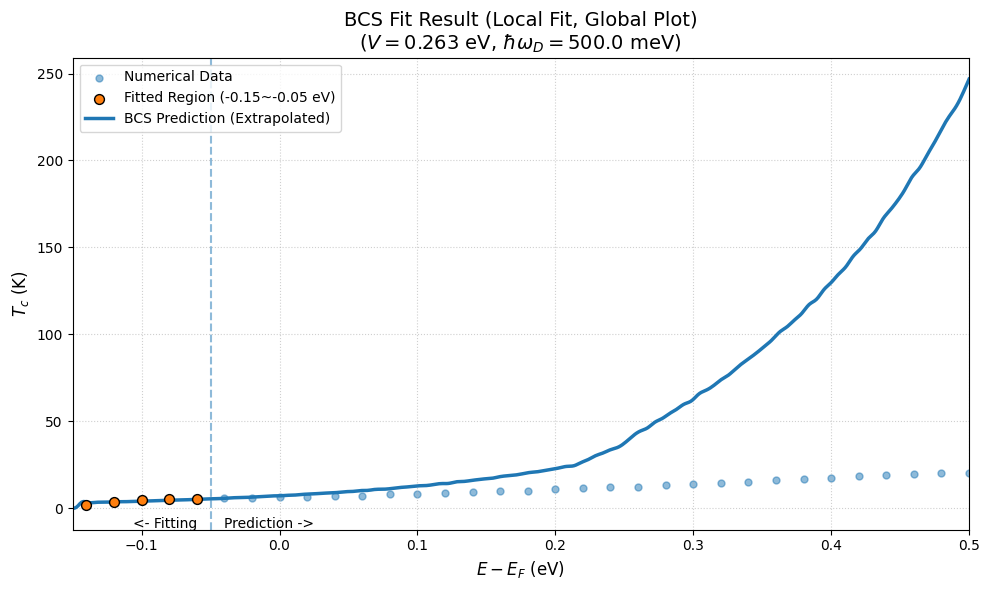

In [25]:
# =========================
# 2. 用直方图 DOS 构建插值 N(E)
# =========================
def build_dos_interp_from_hist_SOC(mu_guess, EF,
                                   alpha_Z, alpha_R, fK, beta,
                                   Nk=5001, n_bins=200,
                                   E_rel_range=(-0.2, 0.6)):
    """
    用 compute_DOS_relative_SOC 计算 DOS，并构建 N(E - E_F) 插值。
    """

    print("正在用 SOC DOS 构建插值 N(E - E_F)...")

    # 用你前面写的包含 SOC 的 DOS 函数
    E_rel, DOS_vals = compute_DOS_relative_SOC(
        mu_guess, EF,
        alpha_Z, alpha_R, fK, beta,
        Nk=Nk,
        n_bins=n_bins,
        E_rel_range=E_rel_range
    )

    # 防止 NaN
    DOS_vals = np.nan_to_num(DOS_vals, nan=0.0)

    # cubic 插值
    N_E_func = interp1d(E_rel, DOS_vals,
                        kind='cubic',
                        fill_value="extrapolate")
    return N_E_func

# --- 构建 N_E_func（相对能量单位是 E - E_F）---
mu_guess = 0.0  # 你前面 EF 的定义里用到的 mu_guess
dos_calc_min = -0.2
dos_calc_max = 0.6

N_E_func = build_dos_interp_from_hist_SOC(
    mu_guess, E_F,
    alpha_Z, alpha_R, fK, beta,
    Nk=5001,
    n_bins=150,
    E_rel_range=(dos_calc_min, dos_calc_max)
)


# =========================
# 3. 准备拟合数据 (范围: -0.15 到 0 eV)
# =========================
print("\n准备进行局部拟合...")

fit_min_E = -0.15
fit_max_E = -0.05

mask_range = (dE_plot >= fit_min_E) & (dE_plot <= fit_max_E)
mask_valid = Tc_plot > 0.01  # 过滤掉 Tc=0
mask_fit = mask_range & mask_valid

E_fit_data = dE_plot[mask_fit]      # 这里的横轴就是 E - E_F
Tc_fit_data = Tc_plot[mask_fit]

# 用你提供的 DOS 插值函数计算 N(E)
N0_fit_data = N_E_func(E_fit_data)

print(f"拟合范围: [{fit_min_E}, {fit_max_E}] eV")
print(f"有效拟合点数: {len(E_fit_data)}")


# =========================
# 4. BCS 拟合
# =========================
def bcs_model(N_E, V, hwD_eV):
    """
    标准 BCS 公式: Tc = 1.13 * hwD * exp(-1 / (N(E)*V))
    """
    val = N_E * V
    val = np.maximum(val, 1e-12)  # 防止除零

    prefactor = 1.13 * hwD_eV / k_B_eV
    return prefactor * np.exp(-1.0 / val)

# 初始猜测 & 边界
p0 = [1.0, 0.02] 
bounds = ([0.01, 0.0001], [50.0, 0.5])

try:
    popt, pcov = curve_fit(bcs_model, N0_fit_data, Tc_fit_data,
                           p0=p0, bounds=bounds)
    V_opt, hwD_opt = popt

    residuals = Tc_fit_data - bcs_model(N0_fit_data, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((Tc_fit_data - np.mean(Tc_fit_data))**2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

    print("-" * 30)
    print("局部 Best Fit 拟合成功!")
    print(f"V_eff       = {V_opt:.4f} eV")
    print(f"hbar * w_D  = {hwD_opt * 1000:.2f} meV")
    print(f"R^2 (local) = {r_squared:.4f}")
    print("-" * 30)

except Exception as e:
    print(f"拟合失败: {e}")
    V_opt, hwD_opt = 1.0, 0.02


# =========================
# 5. 绘图对比
# =========================
fig, ax1 = plt.subplots(figsize=(10, 6))

plot_x_min = -0.15
plot_x_max = 0.5

# 只画展示范围内的数值点
plot_mask = (dE_plot >= plot_x_min) & (dE_plot <= plot_x_max)
ax1.scatter(dE_plot[plot_mask], Tc_plot[plot_mask],
            alpha=0.5, label='Numerical Data', s=25)

# 高亮拟合区间数据
ax1.scatter(E_fit_data, Tc_fit_data,
            label=f'Fitted Region ({fit_min_E}~{fit_max_E} eV)',
            s=50, edgecolors='k', zorder=5)

# BCS 理论曲线（用同一个 N_E_func 外推到整个区间）
E_dense = np.linspace(plot_x_min, plot_x_max, 500)
N_dense = N_E_func(E_dense)
Tc_bcs_dense = bcs_model(N_dense, V_opt, hwD_opt)

ax1.plot(E_dense, Tc_bcs_dense,
         linewidth=2.5, linestyle='-',
         label='BCS Prediction (Extrapolated)')

ax1.set_xlim(plot_x_min, plot_x_max)
ax1.set_xlabel(r'$E - E_F$ (eV)', fontsize=12)
ax1.set_ylabel(r'$T_c$ (K)', fontsize=12)
ax1.set_title(
    f'BCS Fit Result (Local Fit, Global Plot)\n'
    f'($V={V_opt:.3f}$ eV, $\\hbar\\omega_D={hwD_opt*1000:.1f}$ meV)',
    fontsize=14
)
ax1.legend(loc='upper left')
ax1.grid(True, linestyle=':', alpha=0.6)

# 画出拟合边界线
ax1.axvline(x=fit_max_E, linestyle='--', alpha=0.5)
ax1.text(fit_max_E + 0.01, ax1.get_ylim()[0] + 1,
         'Prediction ->', fontsize=10)
ax1.text(fit_max_E - 0.01, ax1.get_ylim()[0] + 1,
         '<- Fitting', fontsize=10, horizontalalignment='right')

plt.tight_layout()
plt.show()